In [325]:

import os
os.chdir("D:\\flask-app-master")
os.getcwd()
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly
plotly.offline.init_notebook_mode() # run at the start of every notebook
import pandas as pd
import datetime as dt
import seaborn as sns
from matplotlib.pyplot import cm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from flask import Flask,flash,abort, current_app, jsonify, Response,session, render_template, request, redirect,send_file, make_response
import requests
import plotly
import pandas as pd

import json

import numpy as np
    

In [283]:
if __name__ == '__main__':
    colnames = ['id', 'duration', 's_date', 'start_station',
                 's_terminal', 'e_date', 'end_station', 'e_terminal',
                 'bike', 'type', 'zip']
    #changing column names for ease of data
    #reading full raw data

    full_data = pd.read_csv(".\GDADATA\GDA_DATA.csv", names=colnames,skiprows=[0],low_memory= False,skipinitialspace=True)
    full_data['duration'] = full_data['duration'].apply(lambda x: x/60)   
    full_data.duration = full_data.duration.round()


In [284]:
def prepare_data(data):
    '''
        Data Quality check and improvement
    '''
    
    #Changing duration of rides into minutes
    
     #splitting date and time  
    data['s_date'] =  pd.to_datetime(data['s_date'], format='%m/%d/%Y %H:%M')
    data['start_date'] = [d.date() for d in data['s_date']]
    data['start_time'] = [d.time() for d in data['s_date']]

    data['e_date'] =  pd.to_datetime(data['e_date'], format='%m/%d/%Y %H:%M')
    data['end_date'] = [d.date() for d in data['e_date']]
    data['end_time'] = [d.time() for d in data['e_date']]

    #splitting hour of day
    data['start_hour'] = data.start_time.apply(lambda x: x.hour)
    data['end_hour'] = data.end_time.apply(lambda x: x.hour)
    
    #splitting year and month
    data['year'], data['month'] = data['start_date'].apply(lambda x: x.year), data['end_date'].apply(lambda x: x.month)

    #dropping prior column of datetime
    data = data.drop(['s_date','e_date'], axis=1)
    
    #with weekday identifying weekdays and weekends of the week
    data['day'] = data['start_date'].apply(lambda x: x.weekday())
    '''
    data['day'].replace([0,1,2,3,4], 'Weekday',inplace=True)
    data['day'].replace([5,6], 'Weekend',inplace=True)
    '''
    data['day'].replace(0, 'Monday',inplace=True)
    data['day'].replace(1, 'Tuesday',inplace=True)
    data['day'].replace(2, 'Wednesday',inplace=True)
    data['day'].replace(3, 'Thursday',inplace=True)
    data['day'].replace(4, 'Friday',inplace=True)
    data['day'].replace(5, 'Saturday',inplace=True)
    data['day'].replace(6, 'Sunday',inplace=True)
    
    #changing month number into month name
    import calendar
    data['month'] = data['month'].apply(lambda x: calendar.month_abbr[x])
    
    #making hour, month, year, day as categorical values
    data[['start_hour', 'end_hour','year','month','day']].apply(lambda x: x.astype('category'))
    
    #cutting duration of rides into buckets of minutes 
    def duration_bucket(a):
        if a <= 5: return '<5'
        elif 5 < a <= 10 : return '5-10 min'
        elif 10 < a <= 15: return '10-15 min'
        elif 15 < a <= 20: return '15-20 min'
        elif 20 < a <= 25 : return '20-25 min'
        elif 25 < a <= 30: return '25-30 min'
        elif 30 < a <= 35: return '30-35 min'
        elif 35 < a <= 40 : return '35-40 min'
        elif 40 < a <= 45: return '40-45 min'
        elif 45 < a <= 50: return '45-50 min'
        elif 50 < a <= 55 : return '50-55 min'
        elif 55 < a <= 60: return '55-60 min'
        elif 60 < a <= 180: return '1-3 hour'
        elif 180 < a <= 360 : return '3-6 hour'
        elif 360 < a <= 540: return '6-9 hour'
        elif 540 < a <= 720: return '9-12 hour'
        elif 12 < a <= 24 : return '12-24 hour'
        else: return '> 1day'
    
    data['d_bucket'] = data['duration'].apply(lambda c: duration_bucket(c))
    
    return data

In [285]:
data=prepare_data(full_data)
data.head()

id  duration                   start_station  s_terminal  \
0  432946       7.0  Mountain View Caltrain Station          28   
1  432945       8.0                 Beale at Market          56   
2  432944       9.0                 Beale at Market          56   
3  432942      17.0          Embarcadero at Sansome          60   
4  432941      18.0          Embarcadero at Sansome          60   

                        end_station  e_terminal  bike        type    zip  \
0  Castro Street and El Camino Real          32    17  Subscriber  94040   
1                     Market at 4th          76   509    Customer  11231   
2                     Market at 4th          76   342    Customer  11231   
3                 Steuart at Market          74   603    Customer  94521   
4                 Steuart at Market          74   598    Customer  94521   

   start_date start_time    end_date  end_time  start_hour  end_hour  year  \
0  2014-08-31   22:31:00  2014-08-31  22:38:00          22        22  2014   
1  2014-08-31   22:07:00  2014-08-31  22:15:00          22        22  2014   
2  2014-08-31   22:06:00  2014-08-31  22:15:00          22        22  2014   
3  2014-08-31   21:45:00  2014-08-31  22:02:00          21        22  2014   
4  2014-08-31   21:44:00  2014-08-31  22:02:00          21        22  2014   

  month     day   d_bucket  
0   Aug  Sunday   5-10 min  
1   Aug  Sunday   5-10 min  
2   Aug  Sunday   5-10 min  
3   Aug  Sunday  15-20 min  
4   Aug  Sunday  15-20 min

In [286]:
'''
Pie plot to analyze customer segment type
'''
def plot_type(df):
    sub_per = pd.DataFrame({'sub_Count': df.groupby(['type']).size()})
    print(sub_per)
    sizes = sub_per['sub_Count'].tolist()
    labels = 'subscribers', 'custumers'
    values=sub_per.sub_Count
    trace = go.Pie(labels=labels, values=values)
    plotly.offline.iplot([trace], filename='basic_pie_chart-line.png')

  

In [287]:
plot_type(full_data)

            sub_Count
type                 
Customer        28910
Subscriber     142882


In [258]:
'''
PLot for total number of rides for over all time period
'''


dd = pd.DataFrame({'count': data.groupby(['start_date']).size()}).reset_index()

trace = go.Scatter(
    x = dd['start_date'],
    y = dd['count']
)
plot_data = [trace]

layout = go.Layout(
    title='Total Ride Duration per day',
    yaxis=dict(title='Total Length of rides'),
    xaxis=dict(title='Date')
)

fig = go.Figure(data=plot_data, layout=layout)

plotly.offline.iplot(fig, filename='Trend_Number_of_rides_per_day')

In [257]:
'''
PLot for total duration of rides for over all time period
'''
dd = pd.DataFrame({'duration': data.groupby(['start_date'])['duration'].sum()}).reset_index()

trace = go.Scatter(
    x = dd['start_date'],
    y = dd['duration']
)
plot_data = [trace]

layout = go.Layout(
    title='Total Rides per day',
    yaxis=dict(title='Total Number of rides'),
    xaxis=dict(title='Date')
)

fig = go.Figure(data=plot_data, layout=layout)

plotly.offline.iplot(fig, filename='basic-line.png')


In [264]:
def plot_data(data, group_by, kind='area'):
    '''
       param:data = Data frame
       param: column group "type" or "day" 
       param : area or bar graph
       Data is filtered and grouped based on colum value provided
       returns: seaborn graph
    '''
    
    data_grouped = data[['duration', group_by, 'start_date']] \
                        .groupby([group_by, 'start_date']) \
                        .agg({"duration": {'Total_Duration': 'sum', 
                                  'Number_of_Rides': 'count'}}) \
                        .reset_index()

    data_grouped.columns = [''.join(col).strip().replace('duration', '') for col in
                              data_grouped.columns.values]

    print(data_grouped.head())
    cols = ['Number_of_Rides', 'Total_Duration']


    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    sns.set_style("whitegrid")
    cmap = cm.get_cmap('Dark2', 11)
    
    for i in range(len(cols)):
       
        data_group = data_grouped.pivot('start_date', group_by, cols[i])
        data_group.index = [str(x) for x in data_group.index]
       
        # Plotting on a (2,2) panel
        axes[i].set_title(cols[i])
        fig.tight_layout(pad=3)
        
        data_group.plot(kind=kind, stacked=True, legend=None, ax=axes[i], cmap=cmap)
        handles, labels = axes[0].get_legend_handles_labels()
        lg = axes[1].legend(handles, labels, bbox_to_anchor=(1.3, 1), loc=0, fontsize=10)
        for lo in lg.legendHandles:
            lo.set_linewidth(10)

       type  start_date  Total_Duration  Number_of_Rides
0  Customer  2014-03-01         10129.0              125
1  Customer  2014-03-02          6587.0               67
2  Customer  2014-03-03          1049.0               40
3  Customer  2014-03-04          5074.0               48
4  Customer  2014-03-05          7130.0               75


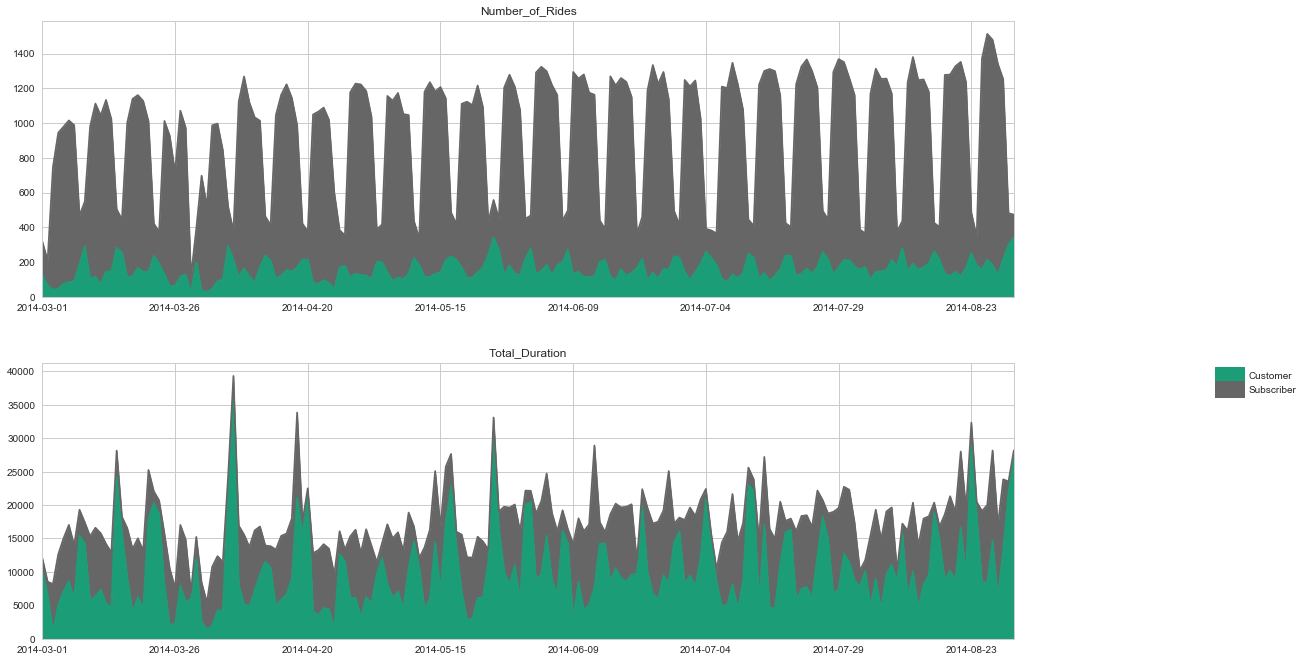

In [265]:

plot_data(data,group_by= 'type', kind='area')

      day  start_date  Total_Duration  Number_of_Rides
0  Friday  2014-03-07         13989.0              988
1  Friday  2014-03-14         12906.0             1022
2  Friday  2014-03-21         25248.0             1010
3  Friday  2014-03-28         14844.0              974
4  Friday  2014-04-04         11500.0              844


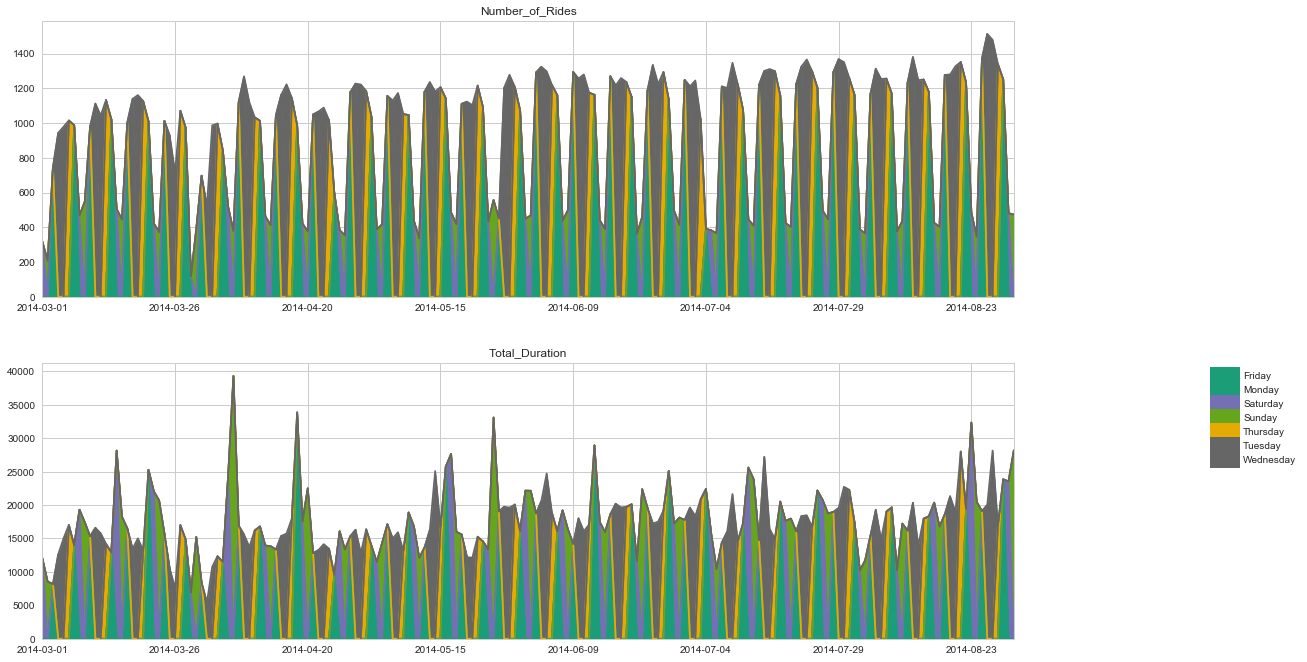

In [266]:

plot_data(data,group_by= 'day', kind='area')

      day  start_date  Total_Duration  Number_of_Rides
0  Friday  2014-08-01         17410.0             1162
1  Friday  2014-08-08         19640.0             1170
2  Friday  2014-08-15         18321.0             1179
3  Friday  2014-08-22         19415.0             1235
4  Friday  2014-08-29         23844.0             1252


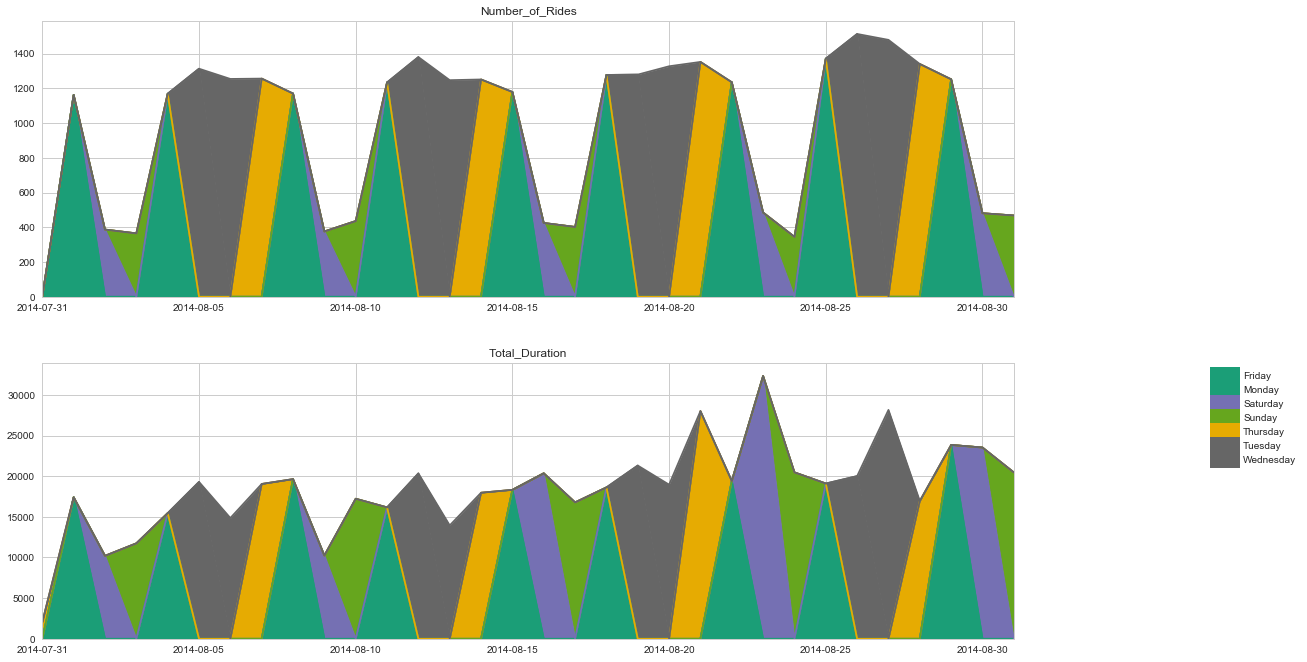

In [267]:
#analyse by individual month

df=data[data["month"]=="Aug"]
plot_data(df, group_by='day', kind='area')

In [1]:
'''
       param:data = Data frame
       param: secondary group : "column name" ("start station","end station","time","month","day")
       param analyse_by: total number or total durationof rides
       param: primary group "type" Customer or Subscriber

       Data is filtereed and grouped based on secondary and primary group provided
       if top values are selected then data is sorted for major group required.
       returns: data, data_col: grouped data, data_col for analyse by
'''

def plot_by(data, secondary_group, primary_group,analyse_by, top=True,
                      title='', ylab='', xlab='', kind='bar'):   

    
    # grouping rides primary and secondary group of given columns
    data_grouped = data[['duration', primary_group, secondary_group]]         .groupby([primary_group, secondary_group])         .agg({"duration": {'Total Duration': 'sum', 
                                  "Total Rides": 'count'}}).reset_index()
    

    data_grouped.columns = [''.join(col).strip().replace('duration', '') for col in data_grouped.columns.values]
    
    if analyse_by=='Number':
    #Filtering and sorting top secondary group passed #Top start or destination station   
    
        tops = data[['duration', secondary_group]].groupby(secondary_group).count().reset_index()

    #selecting only top values for given passed int else no filter applied.
    #no filter applied while stuying graphs for week, month, time wise analysis
        
        data_col="Total Rides"
    else:
        tops = data[['duration', secondary_group]].groupby(secondary_group).sum().reset_index()
        data_col="Total Duration"

        
    
    tops = tops.sort_values(by='duration', ascending=False)                .iloc[:min(top, tops.shape[0]) if top else None]
    tops = list(tops[secondary_group].unique())

    data_grouped = data_grouped.sort_values(by=[data_col, secondary_group, primary_group], ascending=False)
    data_grouped.index = [str(x) for x in data_grouped.index]
    
    #selecting only rows present in top filtered data
    data_grouped = data_grouped[data_grouped[secondary_group].isin(tops)]
    #print(data_grouped)

    #graph
    '''
    for seaborn plot please remove comments
    sns.set(style="whitegrid")
    g = sns.factorplot(x=secondary_group, y=data_col, hue=primary_group, data=data_grouped,
                       kind=kind, size=8, palette="muted", legend_out=False)

    g.set_xticklabels(labels=data_grouped[secondary_group].unique(), rotation=90, fontsize=12)

    g.set_yticklabels(fontsize=12)
    g.despine(left=True)
    g.set_ylabels(ylab+' %s of Rides'%analyse_by)
    g.set_xlabels(xlab )
    g.set(title=title+'Total %s'%analyse_by+' of Rides')
    plt.tight_layout(pad=5)
    plt.show()'''''
    
    
    data_sub=data_grouped[data_grouped[primary_group] == 'Subscriber' ],
    data_sub_1=data_grouped[data_grouped[primary_group] == 'Customer' ]
    trace1 = go.Bar(
        x=data_grouped[data_grouped[primary_group] == 'Subscriber' ][secondary_group],
        y=data_grouped[data_grouped[primary_group] == 'Subscriber' ][data_col],
        name='Subscriber'
    )
    trace2 = go.Bar(
        x=data_grouped[data_grouped[primary_group] == 'Customer' ][secondary_group],
        y=data_grouped[data_grouped[primary_group] == 'Customer' ][data_col],

        name='Customer'
    )

    data = [trace1, trace2]
    layout = go.Layout(title=title+'Total %s'%analyse_by+' of Rides',
        yaxis=dict(title= ylab+' %s of Rides'%analyse_by),
        xaxis=dict(title=xlab),
        barmode='group'
    )
    

    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='basic-line')



In [303]:
#plots top start stations, grouped by customer type to analyse top stations and popularity among customers and subscribers
#analysed by total number of rides
plot_by(data, secondary_group='start_station', primary_group='type',top=10,analyse_by='Number',
                      title='Analysis for Top Start Station by ', ylab='Total', xlab='Station',  kind='bar')

In [304]:
#plots top end stations, grouped by customer type to analyse top stations and popularity among customers and subscribers
#analysed by total number of rides

plot_by(data, secondary_group='end_station', primary_group='type',top=10,analyse_by="Number",
                      title='Analysis for Top Destinations by', ylab='Total', xlab='Stations',  kind='bar')


In [305]:
#analysed by total duration of rides

plot_by(data, secondary_group='start_station', primary_group='type',top=10,analyse_by="Duration",
                      title='Analysis for Top Start Station by ', ylab='Total', xlab='Station',  kind='bar')

In [306]:
plot_by(data, secondary_group='month', primary_group='type',top=False,analyse_by="Number",
                      title='Analysis of Rides Monthly by ', ylab='Total', xlab='Month', kind='bar')

In [307]:
plot_by(data, secondary_group='day', primary_group='type',top=False,analyse_by="Number",
                      title='Analysis of Weekly Rides by ', ylab='Total', xlab='Day', kind='bar')

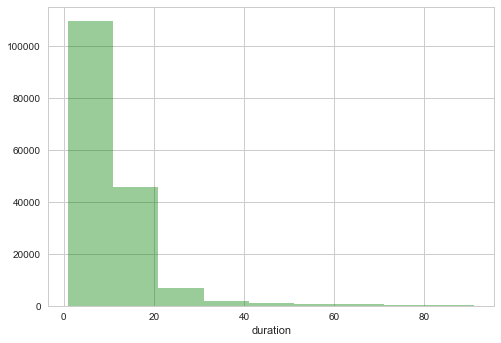

In [308]:
sns.set(style="whitegrid")
fig, ax = plt.subplots()
layout = go.Layout(
    title='Histogram for length of Rides',
    yaxis=dict(title='Total Number of rides'),
    xaxis=dict(title='Date')
)

sns.distplot(data['duration'],bins=range(1, 100, 10), ax=ax, kde=False,color='g')
plt.show()

In [310]:
trace = [go.Histogram(x=data['duration'])]

plotly.offline.iplot(trace, filename='basic histogram')

In [311]:

#analysing data for length of duration 
plot_by(data, secondary_group='d_bucket', primary_group='type',analyse_by="Number",top=False,
                      title='Analysis for length of Each Ride by ', ylab='Total', xlab='Each Ride Length', kind='bar')

In [312]:
#analyzing data for length of duration  greater than 1 hour

data_hour=data[data['duration']>=60]
print(data_hour.shape[0])
plot_by(data_hour, secondary_group='d_bucket', primary_group='type',top=False, analyse_by="Number",
                      title='Analysis for Ride length more than 1 hour by ', ylab='Total', xlab='Each Ride Length', kind='bar')

6145


In [313]:
#analyzing data for by hour of day

data_by_hour  = pd.DataFrame({'Count': data.groupby(['type', 'start_hour',
                                                      ]).size()}).reset_index()

data_by_hour = data_by_hour.sort_values(['Count'], ascending=False)
data_by_hour_grouped = data_by_hour.pivot(index='start_hour', columns='type',
        values='Count').reset_index()
#print(data_by_hour_grouped)       
data_Customer = data_by_hour_grouped['Customer']
data_Subscriber = data_by_hour_grouped['Subscriber']
'''
for seaborn graph please remove comments
fig, ax = plt.subplots(figsize=(15,15))
corner = np.arange(24)
ax.bar(corner, np.array(data_Customer), label='Customer')
ax.bar(corner, np.array(data_Subscriber),bottom=data_Customer,  color='b', label='Subscriber')
        
        
plt.legend(loc='best')
plt.title('Total Number of Rides Picked by hour of Day' )
fig.subplots_adjust(bottom=0.28)
plt.xticks(corner,data_by_hour_grouped['start_hour'],rotation=90, fontsize=12)
plt.yticks()
plt.show()
'''



trace1 = go.Bar(
        x=data_by_hour[data_by_hour['type']=='Customer']['start_hour'],
        y=data_by_hour[data_by_hour['type']=='Customer']['Count'],
        name='Customer'
    )
trace2 = go.Bar(
         x=data_by_hour[data_by_hour['type']=='Subscriber']['start_hour'],
        y=data_by_hour[data_by_hour['type']=='Subscriber']['Count'],
        name='Subscriber'
    )

plot_data = [trace1, trace2]
layout = go.Layout(title="Total Number of Rides Picked by hour of Day",
        yaxis=dict(title= 'Total number of Ride Pick ups'),
        xaxis=dict(title = 'Hour of day'),
        barmode='stack'
    )
    
fig = go.Figure(data=plot_data, layout=layout)
plotly.offline.iplot(fig, filename='basic-hour')

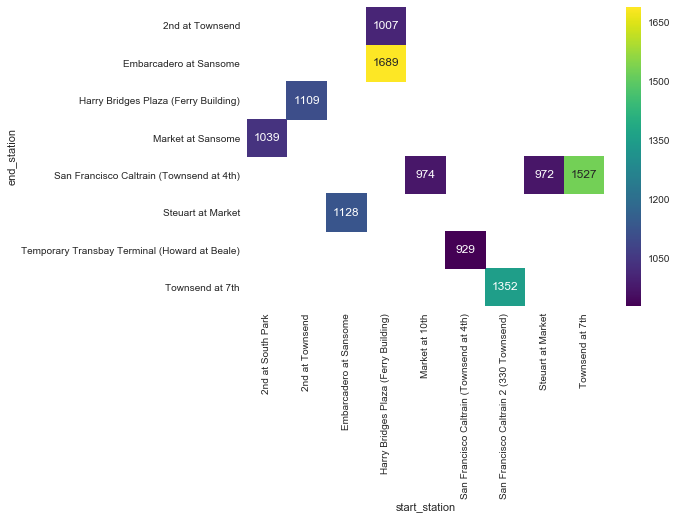

start_station  \
0      Harry Bridges Plaza (Ferry Building)   
1                           Townsend at 7th   
2   San Francisco Caltrain 2 (330 Townsend)   
3                    Embarcadero at Sansome   
4                           2nd at Townsend   
5                         2nd at South Park   
6      Harry Bridges Plaza (Ferry Building)   
7                            Market at 10th   
8                         Steuart at Market   
9  San Francisco Caltrain (Townsend at 4th)   

                                     end_station  Count  
0                         Embarcadero at Sansome   1689  
1       San Francisco Caltrain (Townsend at 4th)   1527  
2                                Townsend at 7th   1352  
3                              Steuart at Market   1128  
4           Harry Bridges Plaza (Ferry Building)   1109  
5                              Market at Sansome   1039  
6                                2nd at Townsend   1007  
7       San Francisco Caltrain (Townsend at 4th)    974  
8       San Francisco Caltrain (Townsend at 4th)    972  
9  Temporary Transbay Terminal (Howard at Beale)    929

In [314]:
data_heatmap  = pd.DataFrame({'Count': data.groupby(['start_station', 'end_station',
                                                      ]).size()}).reset_index()
data_heatmap = data_heatmap.sort_values(['Count'], ascending=False).reset_index(drop=True)
pass_heatmap = data_heatmap[:10]

result = pass_heatmap.pivot(index='end_station', columns='start_station', values='Count')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')
plt.show()
pass_heatmap

In [315]:
import plotly  
plotly.tools.set_credentials_file(username='vashista', api_key='3YjM9mtKIaC4OrPZxLXS')


In [318]:

#heat map to study routes

data_heatmap  = pd.DataFrame({'Count': data.groupby(['start_station', 'end_station',
                                                      ]).size()}).reset_index()
data_heatmap = data_heatmap.sort_values(['Count'], ascending=False)
pass_heatmap = data_heatmap[:20]

layout = go.Layout(title="Total Number of Rides from Start to Destination")
    
trace = go.Heatmap(z=pass_heatmap['Count'],
                   x=pass_heatmap['start_station'],
                   y=pass_heatmap['end_station'])
da=[trace]
plotly.offline.iplot(da, filename='labelled-heatmap')

In [317]:
def trip_metrics(start,dest):
    
    filter_trip = full_data.loc[(full_data['start_station'] == start) & (full_data['end_station'] == dest)].copy()
    trip=prepare_data(filter_trip)

    total_trips = trip.shape[0]

    n_data = data.shape[0]

    duration_mean = trip['duration'].mean()

    duration_metrics = trip['duration'].quantile([.25, .5, .75]).as_matrix()

    print('Average Trips Duration  {:.2f} minutes.'.format(duration_mean))

    print('Median Trip Duration is {:.2f} minutes.'.format(duration_metrics[1]))

    print('25% of Trips are Shorter than {:.2f} minutes.'.format(duration_metrics[0]))

    print('25% of Trips are Longer than {:.2f} minutes.'.format(duration_metrics[2]))
    
    plot_by(trip, secondary_group='day', primary_group='type',top=False,analyse_by="Number",
                      title='Analysis of Weekly Rides by ', ylab='Total', xlab='Day', kind='bar')
    plot_by(trip, secondary_group='month', primary_group='type',top=False,analyse_by="Number",
                      title='Analysis of Rides Monthly by ', ylab='Total', xlab='Month', kind='bar')
    plot_type(trip)

In [300]:
trip_metrics('2nd at Townsend','South Van Ness at Market')

Average Trips Duration  23.83 minutes.
Median Trip Duration is 19.00 minutes.
25% of Trips are Shorter than 17.00 minutes.
25% of Trips are Longer than 21.00 minutes.


C:\Users\vashista\Anaconda3\lib\site-packages\plotly\offline\offline.py:459: UserWarning:

Your filename `basic-line` didn't end with .html. Adding .html to the end of your file.



            sub_Count
type                 
Customer           14
Subscriber         16
